# Sieć klasyfikująca irysy

## Importowanie i omówienie danych wejściowych

In [15]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data # wejścia
y = iris.target
#python -m venv .venv; .venv\Scripts\activate


### Jak prezentują sie dane na wykresie?

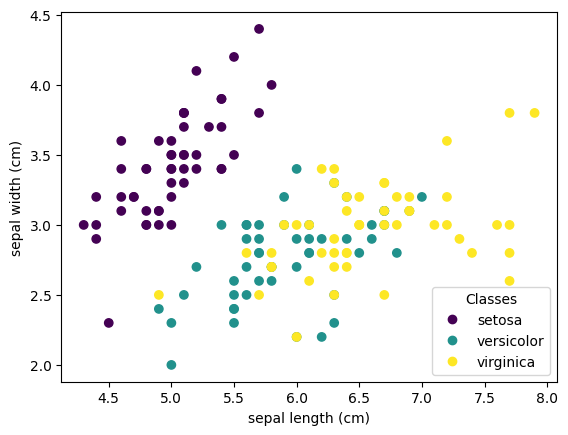

In [16]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

### Jakie informacje podajemy na wejściu?

In [17]:
feature_names = iris.feature_names
feature_names


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### Jakie informacje otrzymujemy na wyjsciu?

In [18]:
terget_names = iris.target_names
terget_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### Zmiana danych na format df

In [19]:
from pandas import DataFrame
df_X = DataFrame(X)

## Standaryzacja danych

### Dane przed standaryzacją

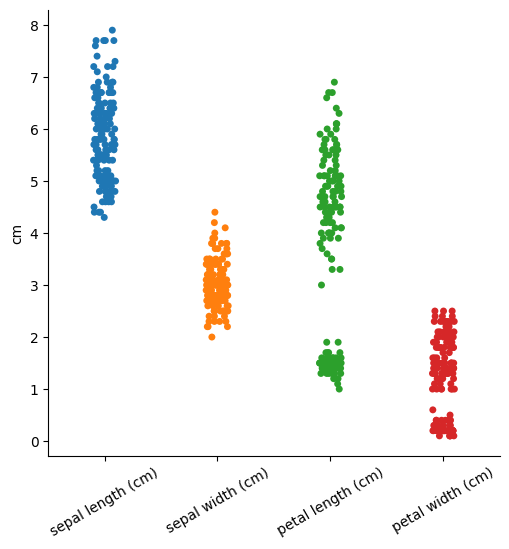

In [20]:
import seaborn as sns

sns.catplot(data=df_X).set_xticklabels(rotation = 30, labels=feature_names).set_ylabels('cm')

### Dane po standaryzacji (dane wycentrowane są w tym samym punkcie, wartość średnia jest równa 0. Istotne przy liczeniu gradientów)

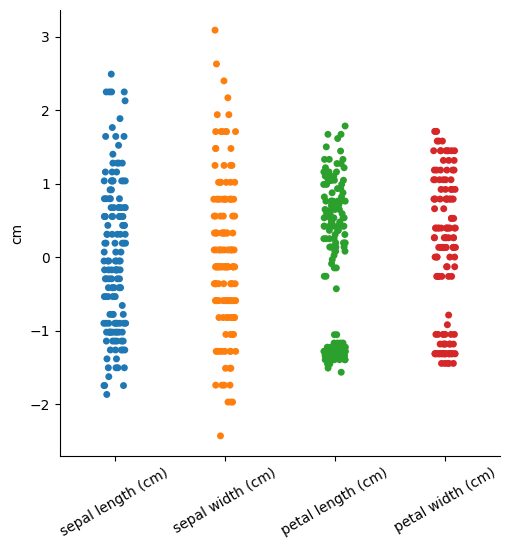

In [21]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

df_X_scaled = DataFrame(X_scaled)
sns.catplot(data=df_X_scaled).set_xticklabels(rotation = 30, labels=feature_names).set_ylabels("cm")

## Obróbka danych wyjściowych, one_hot_encoding klasyfikatora

In [22]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1,1))
y_onehot[1:10]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## Podział na dene treningowe i walidacyjne

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)
X_train[1:10]

array([[-0.17367395,  3.09077525, -1.2833891 , -1.05217993],
       [ 1.03800476,  0.09821729,  0.36489628,  0.26414192],
       [-1.26418478,  0.78880759, -1.22655167, -1.3154443 ],
       [-1.74885626,  0.32841405, -1.39706395, -1.3154443 ],
       [ 0.55333328, -1.28296331,  0.70592084,  0.92230284],
       [ 0.67450115,  0.32841405,  0.42173371,  0.3957741 ],
       [-0.7795133 ,  1.01900435, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.7795133 ,  2.40018495, -1.2833891 , -1.44707648]])

## Zmiana danych trenigowych i walidacyjnych na tensory biblioteki Pytorch

In [24]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

## Tworzenie dataset treningowy oraz obiekt, który pomoże w załadowaniu danych (m.in. batchowaniu)

In [25]:
from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


## Stworzenie modelu

In [26]:
from torch import nn

class NeuralNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(NeuralNet, self).__init__(*args, **kwargs) # Dziedziczenie po klasie Module, zdfinicja konstruktora
        self.fc1 = nn.Linear(4, 10) # 4wejścia -> 20 nauronów 1 warstwy
        self.fc2 = nn.Linear(10, 100) # 10 wejśc -> 100 neuronow 2 warstwy
        self.fc3 = nn.Linear(100, 3) # 100 wyjść z warstwy 2 -> 3 klasy na wyjściu

    def forward(self, x): # przetworzenie danych, czyli wziecie dabych z wejścia i "przepuszczenienie ich przez sieć"
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

## Trening sieci

In [27]:
from torch import optim
model = NeuralNet().to(device)

# Definicja funkcji straty oraz optymatizator
criterion = nn.CrossEntropyLoss() # funkcja błedu, kryterium wg. któego oceniamy sieć, CrossEntropyLoss dobra dla problemów klasyfikacji
optimizer = optim.Adam(model.parameters(), lr=0.001) #optymalizator, aktualizowanie wag w każdej iteracji itd...

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader: #paczki danych
        optimizer.zero_grad() #zerowanie gradientów
        outputs = model(X_batch) # pobranie z modelu przewidywanych wartości
        loss = criterion(outputs, y_batch) # obliczenie błedu 
        loss.backward() # obliczenie gradientów
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Iteracna numer: [{epoch+1} / {num_epochs}], Błąd sieci: {loss:.4f}')

Iteracna numer: [10 / 100], Błąd sieci: 0.7605
Iteracna numer: [20 / 100], Błąd sieci: 0.6321
Iteracna numer: [30 / 100], Błąd sieci: 0.6279
Iteracna numer: [40 / 100], Błąd sieci: 0.7559
Iteracna numer: [50 / 100], Błąd sieci: 0.5860
Iteracna numer: [60 / 100], Błąd sieci: 0.5648
Iteracna numer: [70 / 100], Błąd sieci: 0.6107
Iteracna numer: [80 / 100], Błąd sieci: 0.6036
Iteracna numer: [90 / 100], Błąd sieci: 0.5585
Iteracna numer: [100 / 100], Błąd sieci: 0.5577


## Walidacja modelu

In [28]:
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor) # pobranie z modelu wartości przewidywanych
    _, predicted = torch.max(outputs.data, dim=1) # torch.max poda indeksy pod którymi są maksymalne wartości
    _, y_test_labels = torch.max(y_test_tensor, dim=1)
    accuracy = (predicted == y_test_labels).sum().item() / y_test_labels.size(0)
    print(f'Dokładność modelu na podstawie danych poprawnych: {accuracy*100:.2f}%')
outputs[0:10]

Dokładność modelu na podstawie danych poprawnych: 96.67%


tensor([[4.7524e-04, 9.9688e-01, 2.6464e-03],
        [9.9991e-01, 9.4120e-05, 6.0869e-11],
        [7.1125e-09, 3.8869e-06, 1.0000e+00],
        [1.0081e-03, 9.5126e-01, 4.7730e-02],
        [1.8837e-03, 9.0704e-01, 9.1078e-02],
        [9.9962e-01, 3.7960e-04, 2.4567e-09],
        [9.1088e-04, 9.9870e-01, 3.8581e-04],
        [1.6730e-05, 2.7080e-03, 9.9728e-01],
        [2.2749e-04, 7.1121e-01, 2.8856e-01],
        [6.3697e-04, 9.9835e-01, 1.0087e-03]], device='cuda:0')